In [164]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2
Today date is:  2024-06-13


In [165]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 16400
drwxrwxr-x 1 1000 1000     648 Jun 13 10:01 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
-rw------- 1 1000 1000 1449984 Jun  4 00:49 20240601.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  3 23:44 20240602.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun  4 16:45 20240603.mktdata.ohlcv.db
-rw------- 1 1000 1000 1269760 Jun  5 10:00 20240604.mktdata.ohlcv.db
-rw------- 1 1000 1000 1081344 Jun  6 10:00 20240605.mktdata.ohlcv.db
-rw------- 1 1000 1000 1441792 Jun  7 10:00 20240606.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  8 10:00 20240607.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun  9 10:00 20240608.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun 10 10:00 20240609.mktdata.ohlcv.db
-rw-r--r-- 1 1000 1000       0 Jun 12 15:29 20240609.mktdata.ohlcvdb
-rw------- 1 1000 1000 1437696 Jun 11 10:00 20240610.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun 12 10:01 20240611.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun 13 10:

In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [167]:
directory = "/workspace/data/crypto_md"

# List of dates
dates = ['20240601', 
         '20240602', 
         '20240603', 
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608', 
         '20240609',
         '20240610',
         '20240611',
         '20240612']        

# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    # Print the combined DataFrame
    # print(df_concat.shape[0])
    # print(df_concat.shape[1])
    conn.close()
print(df_concat.shape[0])
# print(df_concat.head(2))
# print(df_concat.tail(2))

66803


In [174]:
df_concat['tstamp'] = pd.to_datetime(df_concat['tstamp'])
# Extract individual components
df_concat['year'] = df_concat['tstamp'].dt.year
df_concat['month'] = df_concat['tstamp'].dt.month
df_concat['day'] = df_concat['tstamp'].dt.day
df_concat['hour'] = df_concat['tstamp'].dt.hour
df_concat['minute'] = df_concat['tstamp'].dt.minute
df_concat['second'] = df_concat['tstamp'].dt.second

df_concat['date'] = df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

# instrument_list = df_concat['instrument_id'].unique().tolist()
# print("Distinct values in column 'instrument_id':", instrument_list)



In [179]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_btc'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_btc'] = df_concat_btc['volume']
df_concat_btc['vwap_btc'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

# print (df_concat_btc.head(3))

# LTC
df_concat_ltc = df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD']

# Reset Index
df_concat_ltc = df_concat_ltc.reset_index(drop = True)

# Rename Vars
df_concat_ltc['close_ltc'] = df_concat_ltc['close']/100.00
df_concat_ltc['volume_ltc'] = df_concat_ltc['volume']
df_concat_ltc['vwap_ltc'] = df_concat_ltc['vwap']/100.00

df_concat_ltc = df_concat_ltc.drop('close', axis = 1)
df_concat_ltc = df_concat_ltc.drop('volume', axis = 1)
df_concat_ltc = df_concat_ltc.drop('vwap', axis = 1)
df_concat_ltc = df_concat_ltc.drop('instrument_id', axis = 1)

# print (df_concat_ltc.head(3))

# ETH
df_concat_eth = df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD']

# Reset Index
df_concat_eth = df_concat_eth.reset_index(drop = True)

# Rename Vars
df_concat_eth['close_eth'] = df_concat_eth['close']/10000.00
df_concat_eth['volume_eth'] = df_concat_eth['volume']
df_concat_eth['vwap_eth'] = df_concat_eth['vwap']/10000.00

df_concat_eth = df_concat_eth.drop('close', axis = 1)
df_concat_eth = df_concat_eth.drop('volume', axis = 1)
df_concat_eth = df_concat_eth.drop('vwap', axis = 1)
df_concat_eth = df_concat_eth.drop('instrument_id', axis = 1)

# print (df_concat_eth.head(3))

# XRP
df_concat_xrp = df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD']

# Reset Index
df_concat_xrp = df_concat_xrp.reset_index(drop = True)

# Rename Vars
df_concat_xrp['close_xrp'] = df_concat_xrp['close']
df_concat_xrp['volume_xrp'] = df_concat_xrp['volume']
df_concat_xrp['vwap_xrp'] = df_concat_xrp['vwap']

df_concat_xrp = df_concat_xrp.drop('close', axis = 1)
df_concat_xrp = df_concat_xrp.drop('volume', axis = 1)
df_concat_xrp = df_concat_xrp.drop('vwap', axis = 1)
df_concat_xrp = df_concat_xrp.drop('instrument_id', axis = 1)

# print (df_concat_xrp.head(3))

df_M1 = pd.merge(df_concat_xrp, df_concat_eth, on = 'date', how = 'outer')
# print (df_M1.head(3))
# print ("M1:  ", df_M1.shape[0])
df_M2 = pd.merge(df_M1, df_concat_ltc, on = 'date', how = 'outer')
# print (df_M2.head(3))
# print ("M2:  ", df_M2.shape[0])
df_M3 = pd.merge(df_M2, df_concat_btc, on = 'date', how = 'outer')
# print (df_M3.head(3))
# print ("M3:  ", df_M3.shape[0])

# Drop rows with any NaN value and assign it to a new DataFrame
# sample = df_M3.dropna(axis = 0).reset_index(drop = True)
print ("========================================")
print (sample.head(3))
sample_size = sample.shape[0]
print ("test sample size: ", sample_size)

     date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0   1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   
1   1-0-1     0.5170  10184.511212  0.517060   0.375942   11.703305  0.376013   
2  1-0-10     0.5176  15515.348778  0.517601   0.375938   11.922897  0.375935   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  
0     0.8317  110.056253  0.831662   0.675060    2.045049  0.674969  
1     0.8312  176.868598  0.831441   0.674947    0.646759  0.675009  
2     0.8311   58.951033  0.831037   0.675507    1.201335  0.675478  
test sample size:  16698


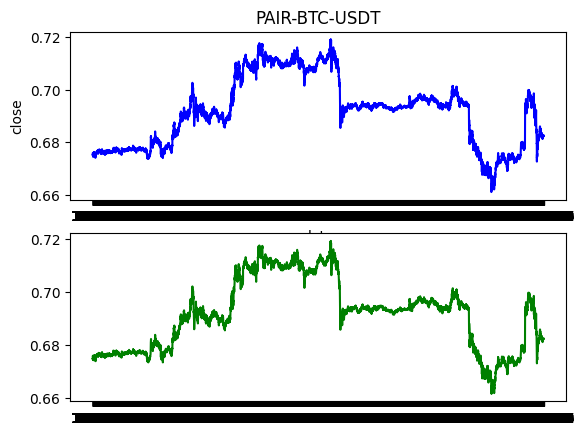

In [177]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_btc'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

In [180]:
split_index = round(sample.shape[0] * 0.8)

# First part of the DataFrame
sample_test = sample.iloc[:split_index]

# Second part of the DataFrame
sample_valid = sample.iloc[split_index:]

print("\nFirst part of the DataFrame:")
print (sample_test.tail(2))

print("\nSecond part of the DataFrame:")
print (sample_valid.head(2))


First part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
13356  7-23-25     0.4995   8673.755143  0.499557   0.368412   53.830657   
13357  7-23-26     0.4996  34403.036949  0.499605   0.368370   89.163024   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
13356  0.368548     0.8003   74.882298  0.800537    0.69375    1.598973   
13357  0.368411     0.8002   30.666566  0.800233    0.69381    1.612419   

       vwap_btc  
13356  0.693999  
13357  0.693838  

Second part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
13358  7-23-27     0.4995   8240.166990  0.499561   0.368369  108.118487   
13359  7-23-28     0.4995  21256.045405  0.499585   0.367813  229.373936   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
13358  0.368353     0.8002   43.931145  0.800134   0.693709    1.765308   
13359  0.368127     0.8002   22.408370  0.800188   

In [182]:
print ('sample_size: ', sample_size)

sample_size:  13358


In [211]:
#  05.17.2024
# ============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 8  # <--- sequence length
batch = 2  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_xrp = np.empty((1, )) # final input/output
all_ts_eth = np.empty((1, )) # final input/output
all_ts_ltc = np.empty((1, )) # final input/output
all_ts_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output

aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # print ('====================')
  sr_before_vwap_xrp = np.array(selected_rows_before['vwap_xrp'])
  sr_after_vwap_xrp = np.array(selected_rows_after['vwap_xrp'])    
  # print (sr_before_vwap_xrp)

# Compute standard deviation
  std_dev_xrp = np.std(sr_before_vwap_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)

  sr_before_vwap_eth = np.array(selected_rows_before['vwap_eth'])
  sr_after_vwap_eth = np.array(selected_rows_after['vwap_eth'])

# Compute standard deviation
  std_dev_eth = np.std(sr_before_vwap_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    

  sr_before_vwap_ltc = np.array(selected_rows_before['vwap_ltc'])
  sr_after_vwap_ltc = np.array(selected_rows_after['vwap_ltc'])

# Compute standard deviation
  std_dev_ltc = np.std(sr_before_vwap_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)
    
  sr_before_vwap_btc = np.array(selected_rows_before['vwap_btc'])
  sr_after_vwap_btc = np.array(selected_rows_after['vwap_btc'])

# Compute standard deviation
  std_dev_btc = np.std(sr_before_vwap_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)
    
  all_ts_xrp = np.concatenate((all_ts_xrp, sr_before_vwap_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
    
  all_ts_eth = np.concatenate((all_ts_eth, sr_before_vwap_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))

  all_ts_ltc = np.concatenate((all_ts_ltc, sr_before_vwap_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))

  all_ts_btc = np.concatenate((all_ts_btc, sr_before_vwap_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))

  aft_ts_xrp = np.concatenate((aft_ts_xrp, sr_after_vwap_xrp))
  aft_ts_eth = np.concatenate((aft_ts_eth, sr_after_vwap_eth))
  aft_ts_ltc = np.concatenate((aft_ts_ltc, sr_after_vwap_ltc))
  aft_ts_btc = np.concatenate((aft_ts_btc, sr_after_vwap_btc))

X_XRP = all_ts_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH = all_ts_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC = all_ts_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC = all_ts_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP, X_XRP_stdev, X_ETH, X_ETH_stdev, X_LTC, X_LTC_stdev, X_BTC, X_BTC_stdev))
print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)

sample_size:  13358
[ 1108 13291]
[[5.18272282e-01 1.68025214e-04 3.77189791e-01 1.45151777e-04
  8.31595503e-01 3.95645238e-04 6.76253699e-01 2.15301382e-04]
 [5.18303634e-01 1.68025214e-04 3.77154892e-01 1.45151777e-04
  8.32082769e-01 3.95645238e-04 6.76271128e-01 2.15301382e-04]
 [5.18562378e-01 1.68025214e-04 3.77397110e-01 1.45151777e-04
  8.30954599e-01 3.95645238e-04 6.76918294e-01 2.15301382e-04]
 [5.18341398e-01 1.68025214e-04 3.77160454e-01 1.45151777e-04
  8.31766697e-01 3.95645238e-04 6.76294450e-01 2.15301382e-04]
 [5.18497467e-01 1.68025214e-04 3.77261769e-01 1.45151777e-04
  8.31990904e-01 3.95645238e-04 6.76269889e-01 2.15301382e-04]
 [5.18698229e-01 1.68025214e-04 3.77392003e-01 1.45151777e-04
  8.31954856e-01 3.95645238e-04 6.76339962e-01 2.15301382e-04]
 [5.18693630e-01 1.68025214e-04 3.77533283e-01 1.45151777e-04
  8.32184637e-01 3.95645238e-04 6.76516962e-01 2.15301382e-04]
 [5.18672691e-01 1.68025214e-04 3.77517862e-01 1.45151777e-04
  8.32276407e-01 3.95645238e-

/tmp/ipykernel_28/500398063.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_test['Selected'] = 0
